# An example usage of  `strymread`
## Analyzing CAN data logged from Giraffee and Panda

### Prerequisite
Install strym. See documentation for installation instruction: https://jmscslgroup.github.io/strym/installation.html

We will read the CAN data file which is recorded via [libpanda](https://jmscslgroup.github.io/libpanda/) using comma.ai Panda devices. You must supply a DBC file for decoding hex messes. If you don't provide DBC file, `strymread` defaults to using RAV4 2019 DBC file which is pre-packaged with `strym`. In this example, we won't be supplying DBC file as data that we are going to read is from Toyota RAV4. `strymread` will use default DBC file. Further, naming of CAN CSV file must have VIN number and strymread will guess whihc DBC file to use.

In [1]:
import strym
from strym import strymread
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
csvfile = '../../PandaData/2020_06_01/2020-06-01-13-01-36_2T3Y1RFV8KC014025_CAN_Messages.csv'
r =strymread(csvfile=csvfile)

/home/ivory/anaconda3/envs/dbn/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Loading BokehJS ...

## We will visualize the counts of all messages
The plot is split into several subplots for brevity. The function returns a count dataframe with Message count by BUS IDs and total counts

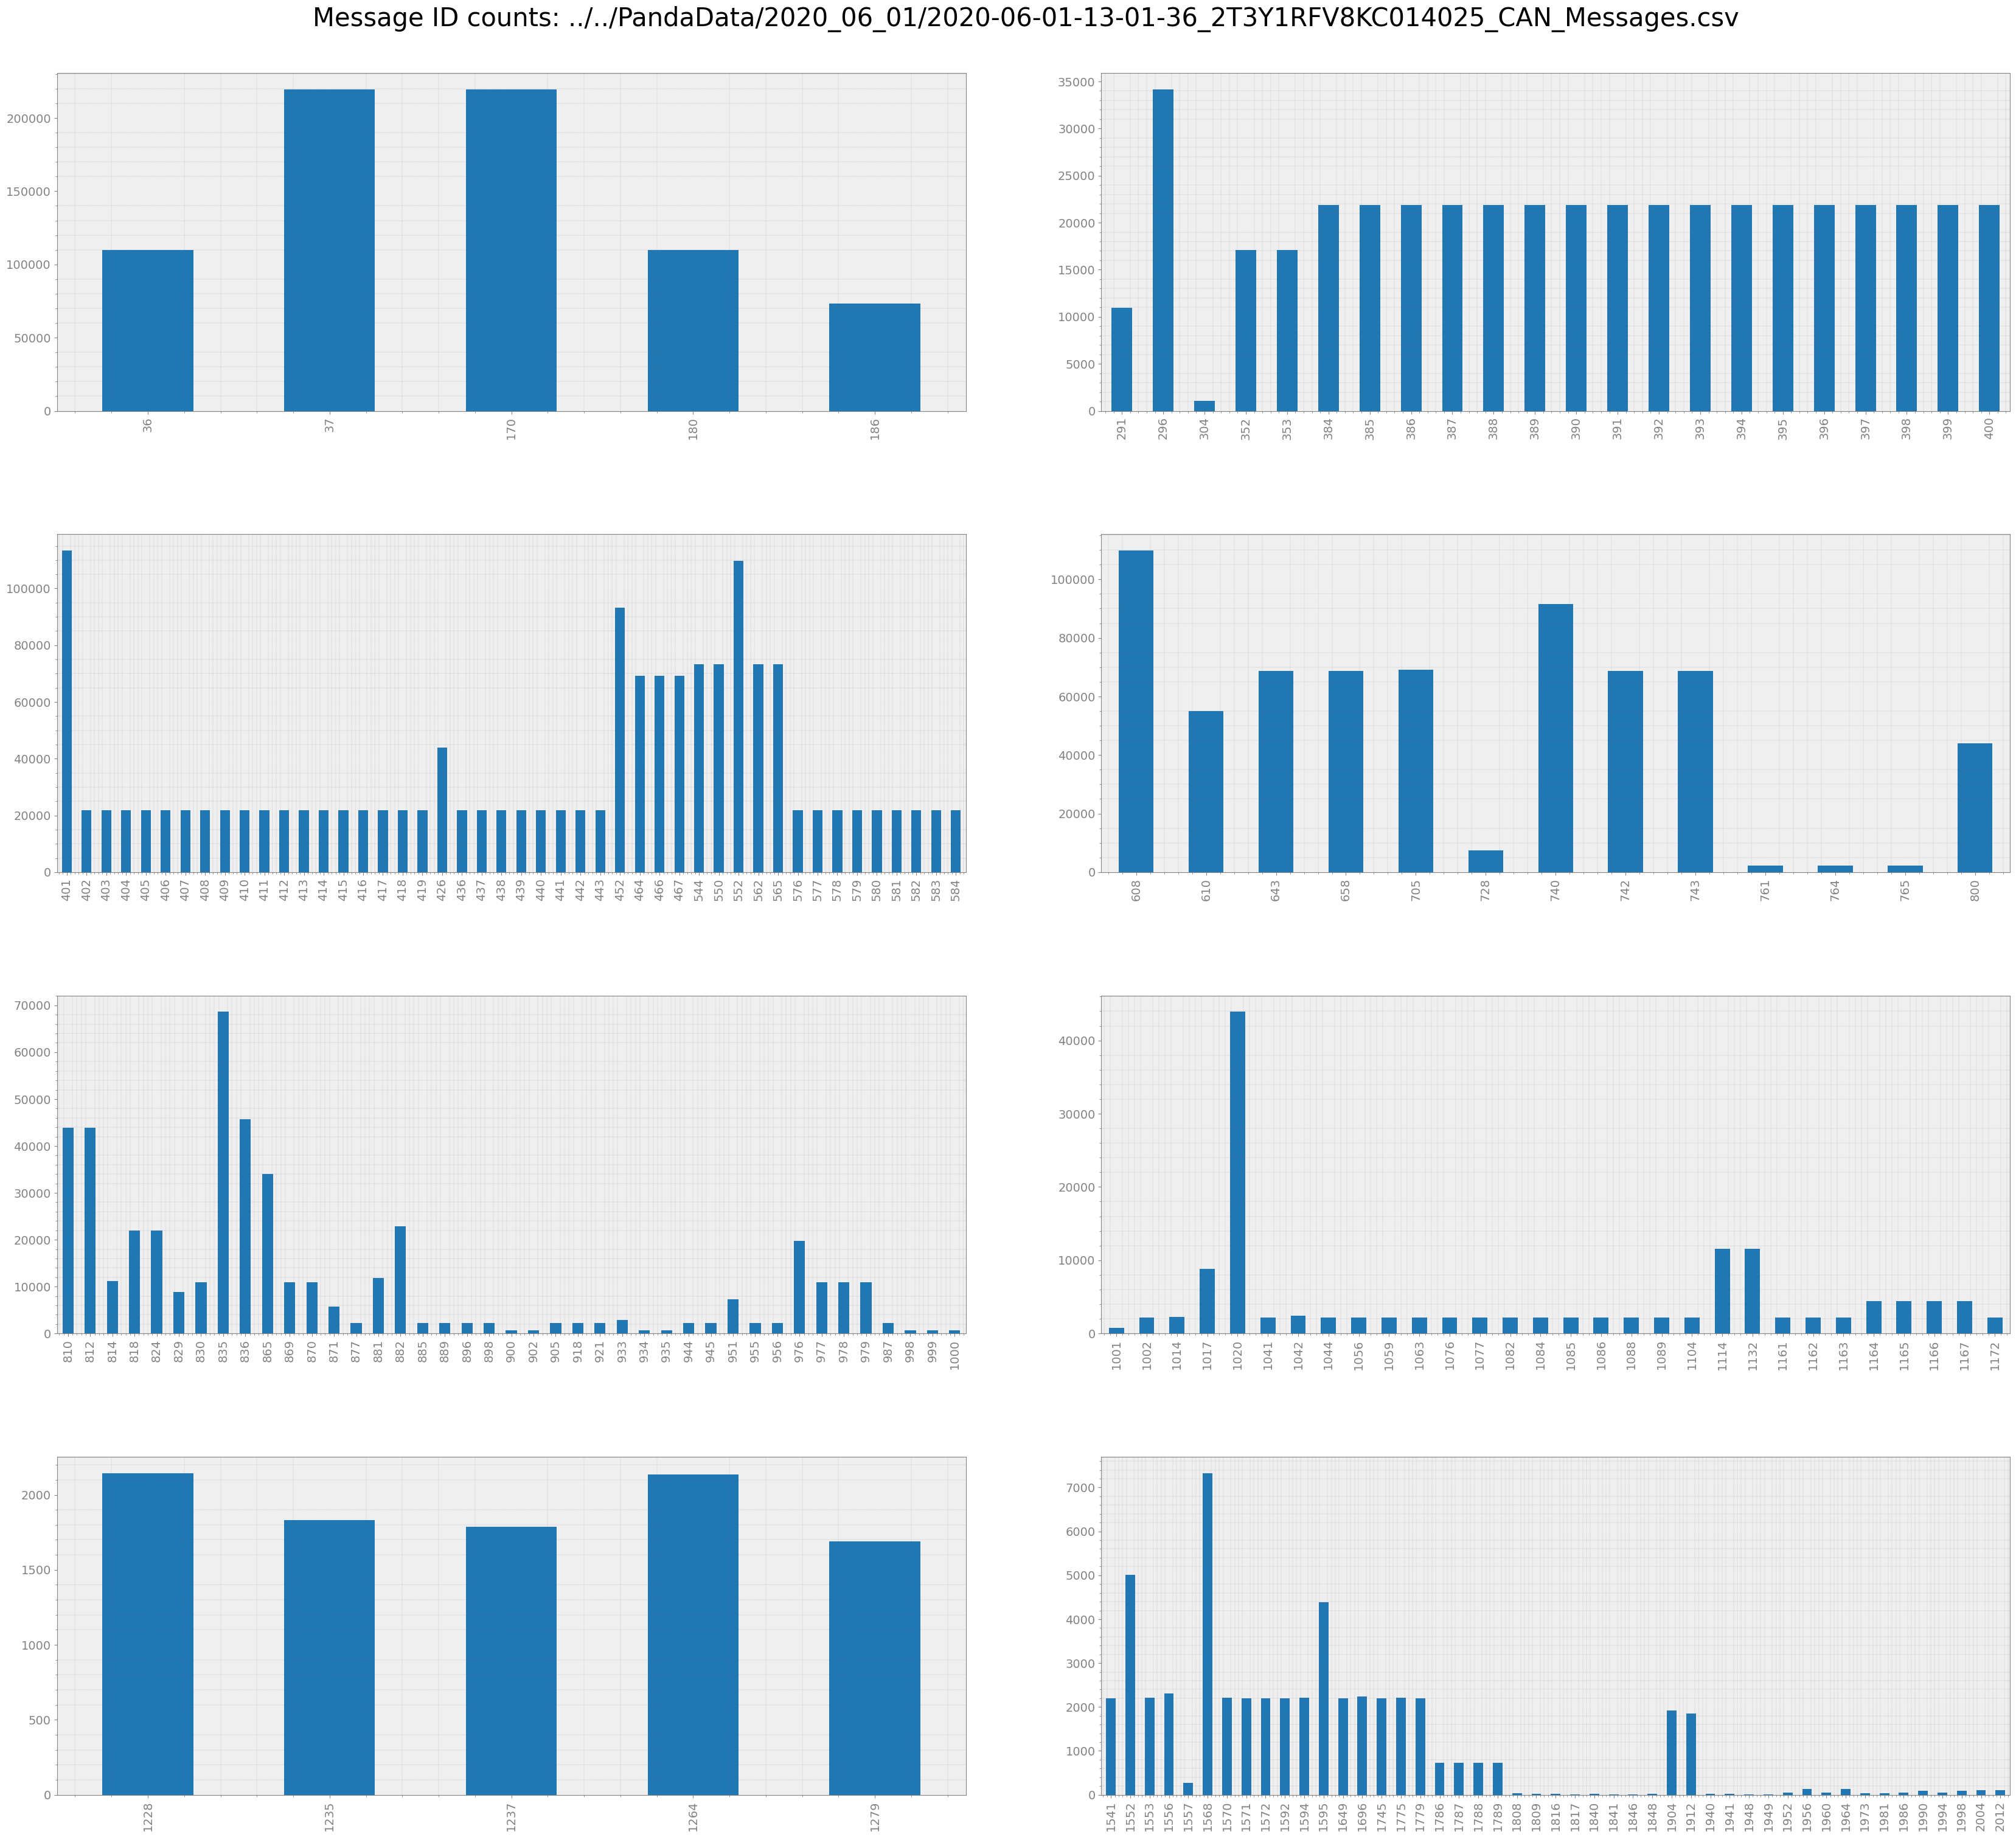

In [2]:
count = r.count(plot=True)

In [3]:
count

,MessageID,Counts_Bus_0,Counts_Bus_1,Counts_Bus_2,TotalCount
36,36,54926,0,54926,109852
37,37,109852,0,109852,219704
170,170,109852,0,109852,219704
180,180,54926,0,54926,109852
186,186,36617,0,36617,73234
...,...,...,...,...,...
1990,1990,45,0,45,90
1994,1994,27,0,27,54
1998,1998,45,0,45,90
2004,2004,52,0,52,104


## Let's plot a few important data
### Speed

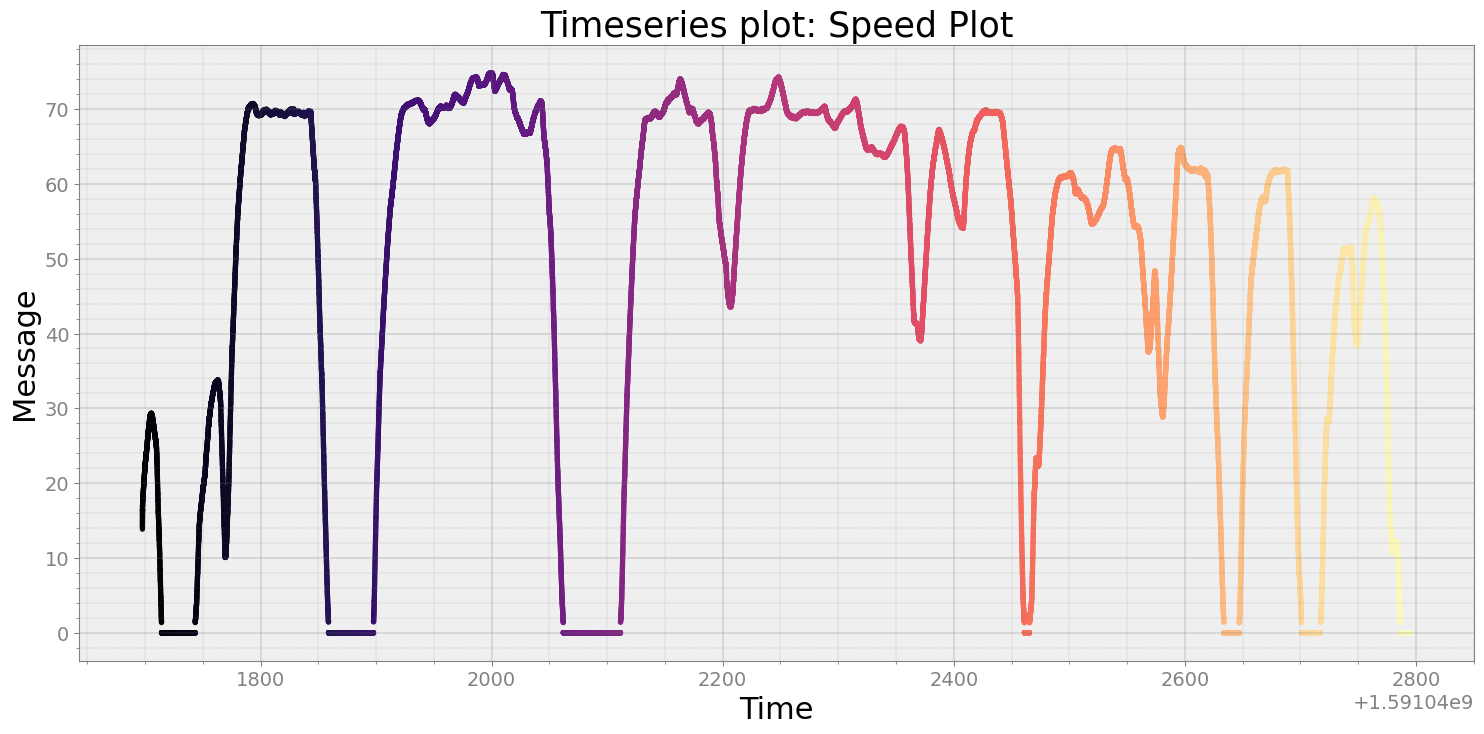

In [4]:
speed = r.speed()
strymread.plt_ts(speed, title="Speed Plot")

## Lets visualize a message with given message ID and  signal ID


In [5]:
msg869 = r.get_ts(869, 6)
msg869

,Time,Message,Bus
Clock,,,
2020-06-01 20:01:37.706951857,1.591042e+09,252,2
2020-06-01 20:01:37.706951857,1.591042e+09,252,0
2020-06-01 20:01:37.727082968,1.591042e+09,252,2
2020-06-01 20:01:37.727082968,1.591042e+09,252,0
2020-06-01 20:01:37.747102022,1.591042e+09,252,2
...,...,...,...
2020-06-01 20:19:54.863569021,1.591043e+09,2,0
2020-06-01 20:19:55.064127922,1.591043e+09,2,2
2020-06-01 20:19:55.064127922,1.591043e+09,2,0


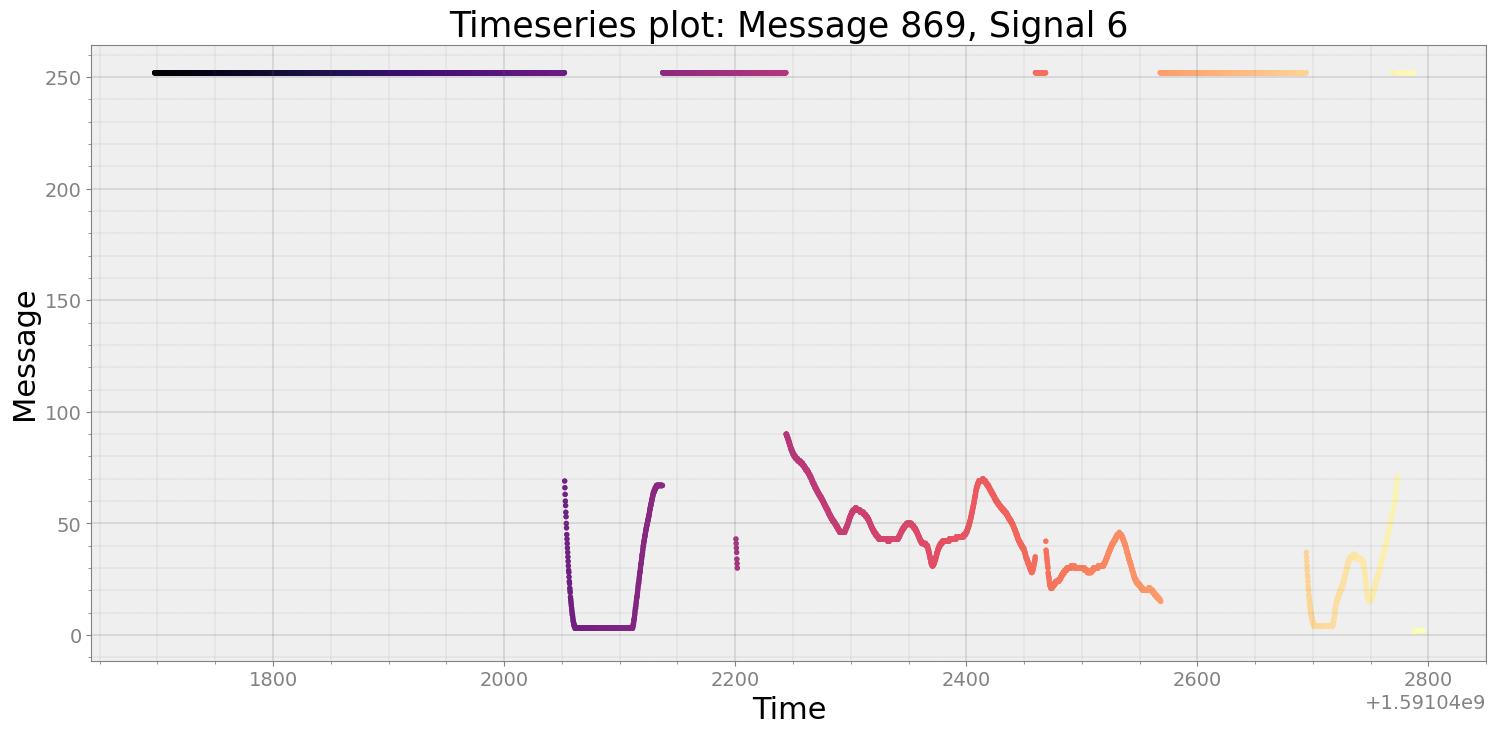

In [6]:
strymread.plt_ts(msg869, title="Message 869, Signal 6")

## Rate Statistics for every message ID

In [7]:
u = r.frequency()
u

,MessageID,MeanRate,MedianRate,RateStd,MaxRate,MinRate,RateIQR
0,36,457.418698,50.127928,1461.255929,12985.461300,11.852837,1.420878
1,37,518.697935,100.563537,1445.840868,11618.570637,13.396566,5.826275
2,170,390.135893,100.301409,1224.572556,11522.813187,13.373116,4.687697
3,180,546.361381,50.153103,1565.040143,12192.744186,12.956059,1.372874
4,186,418.632506,33.459407,1432.105869,11491.243836,11.474896,1.259073
...,...,...,...,...,...,...,...
204,1990,15.867022,10.013666,16.021242,72.290658,0.004203,7.691075
205,1994,785.949826,67.864416,1885.388254,6574.144201,0.033738,102.817044
206,1998,155.187068,10.118899,919.100583,6250.825633,0.004203,14.288731
207,2004,434.944156,10.023070,1506.322766,6061.132948,0.017528,18.321202


## Synchronize Two Time Series messages and resample with a fixed datarate


It means first time of speed is earlier than yaw in time-series data so we have to interpolate speed value at yaw's first time. We will use linear interpolation.

Linear interpolation formula is 

$$
X_i = \cfrac{X_A - X_B}{a-b}(i-b) + X_B
$$

In [8]:
ts_yaw_rate = r.yaw_rate()
ts_speed = r.speed()

# integrate yaw rate to get the heading
ts_yaw = strymread.integrate(ts_yaw_rate)

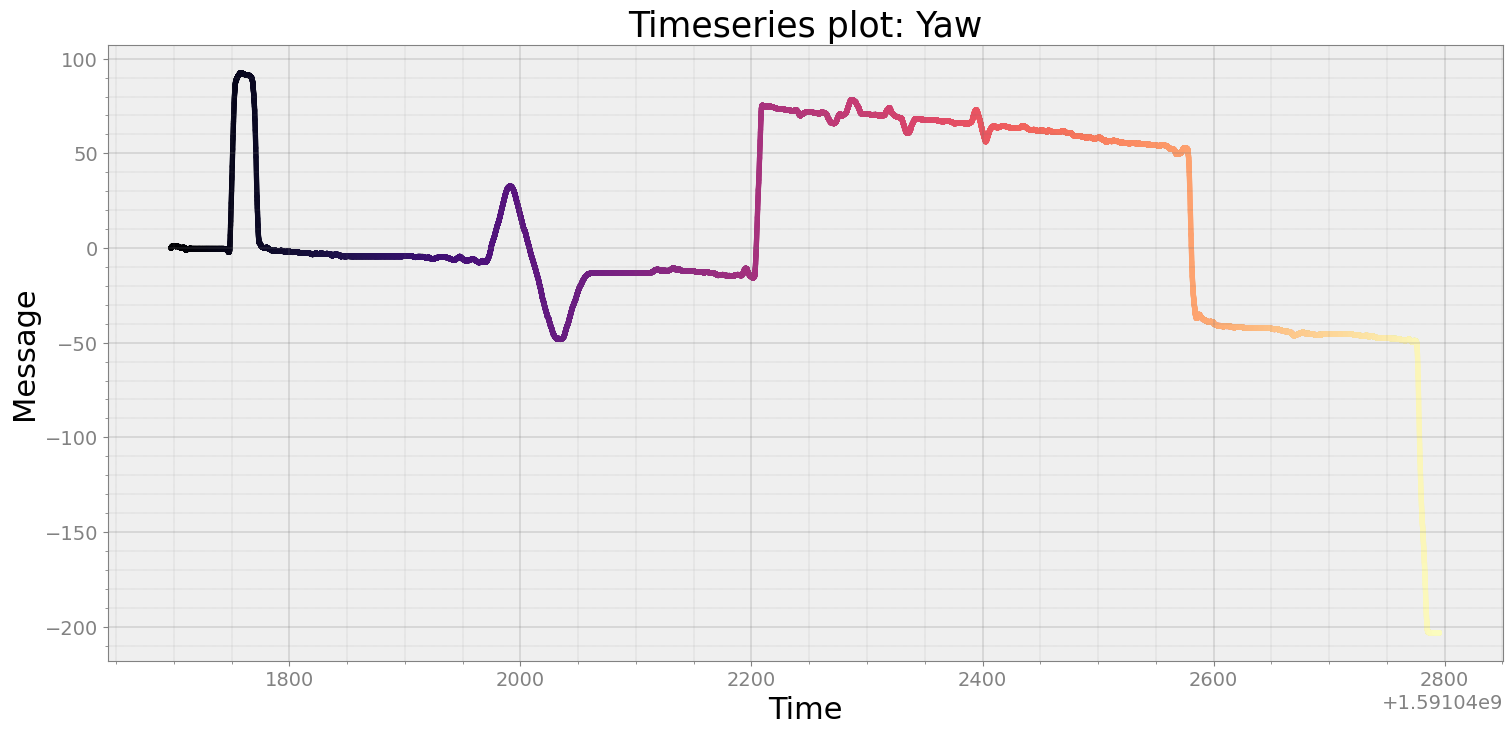

In [9]:
strymread.plt_ts(ts_yaw, title="Yaw")

## We will perform synchornize two timeseries messages so that they both can have same time points. By default, when time-synchronizing, sample rate is 50 Hz. But you can specify some other rates. However, for a good quality synchronization, desired sample rate is recommended to be lower than equal to of minimum of average sample rates of two timeseries.

In [10]:
interpolated_speed, interpolated_yaw = strymread.ts_sync(ts_speed, ts_yaw, rate = 20)

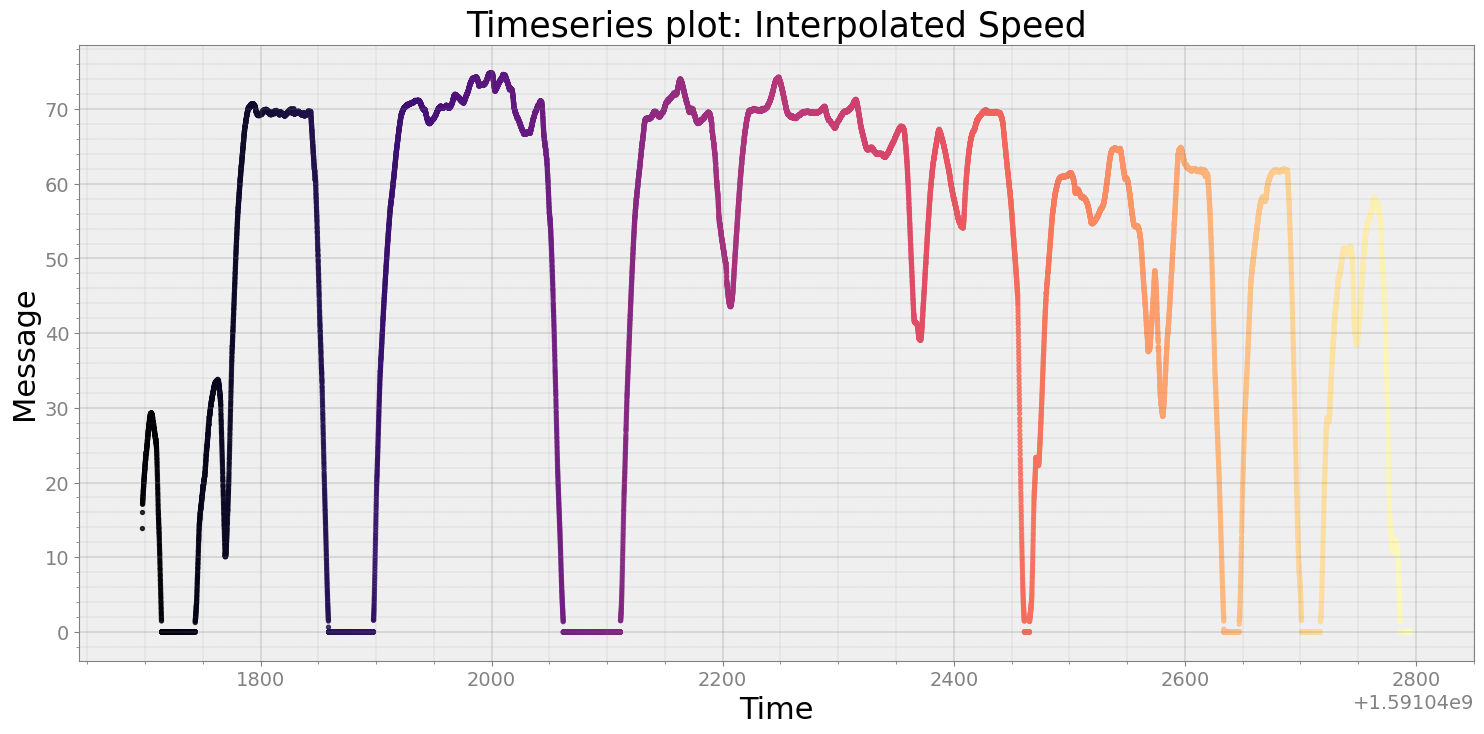

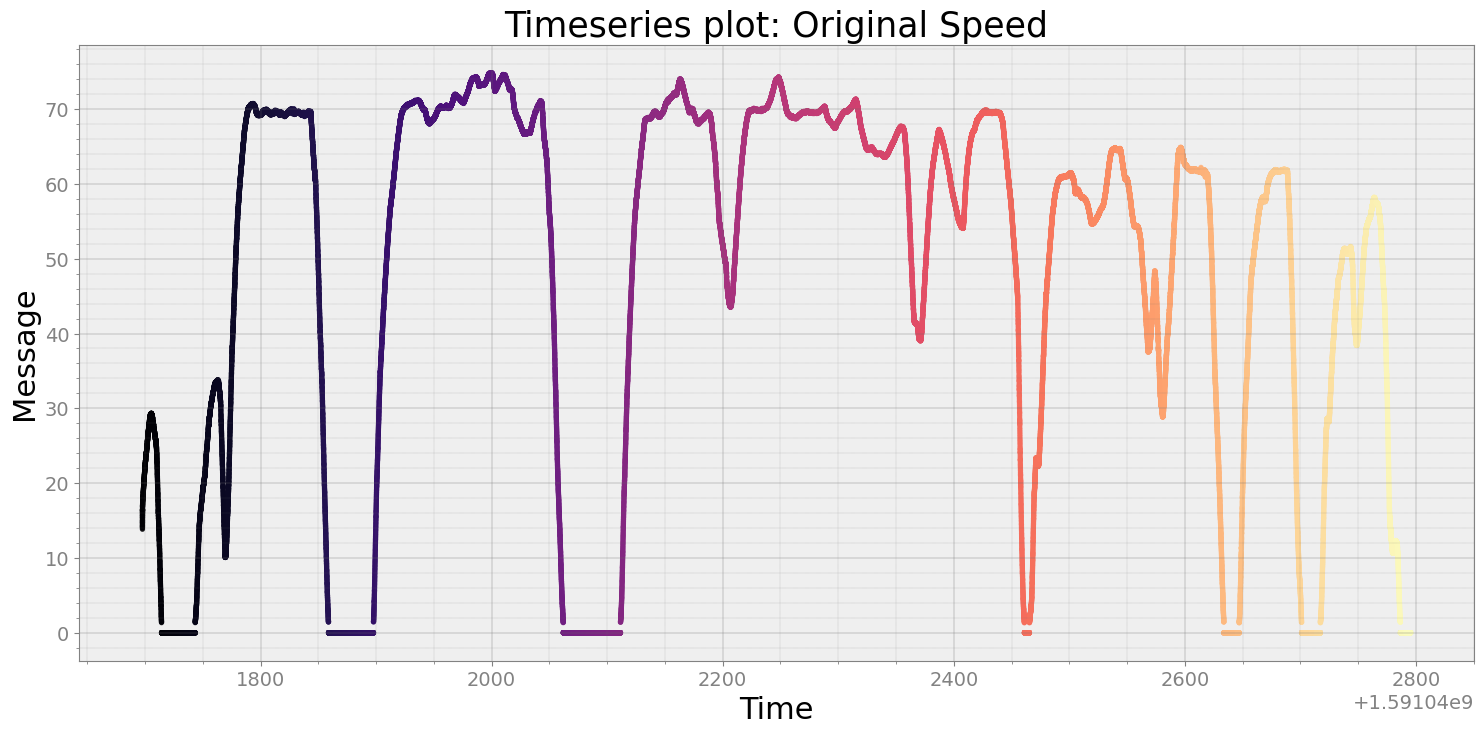

In [11]:
strymread.plt_ts(interpolated_speed, title="Interpolated Speed")
strymread.plt_ts(ts_speed, title="Original Speed")

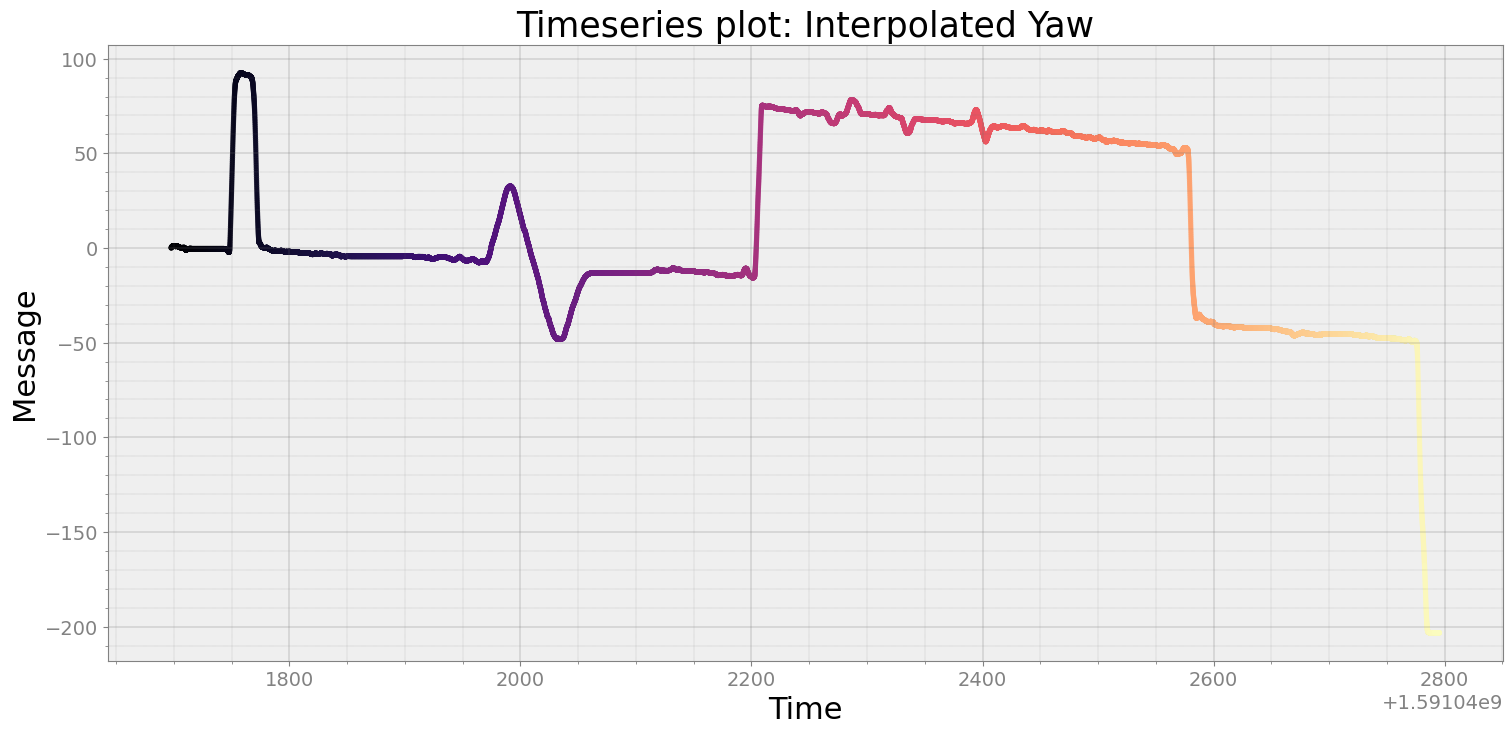

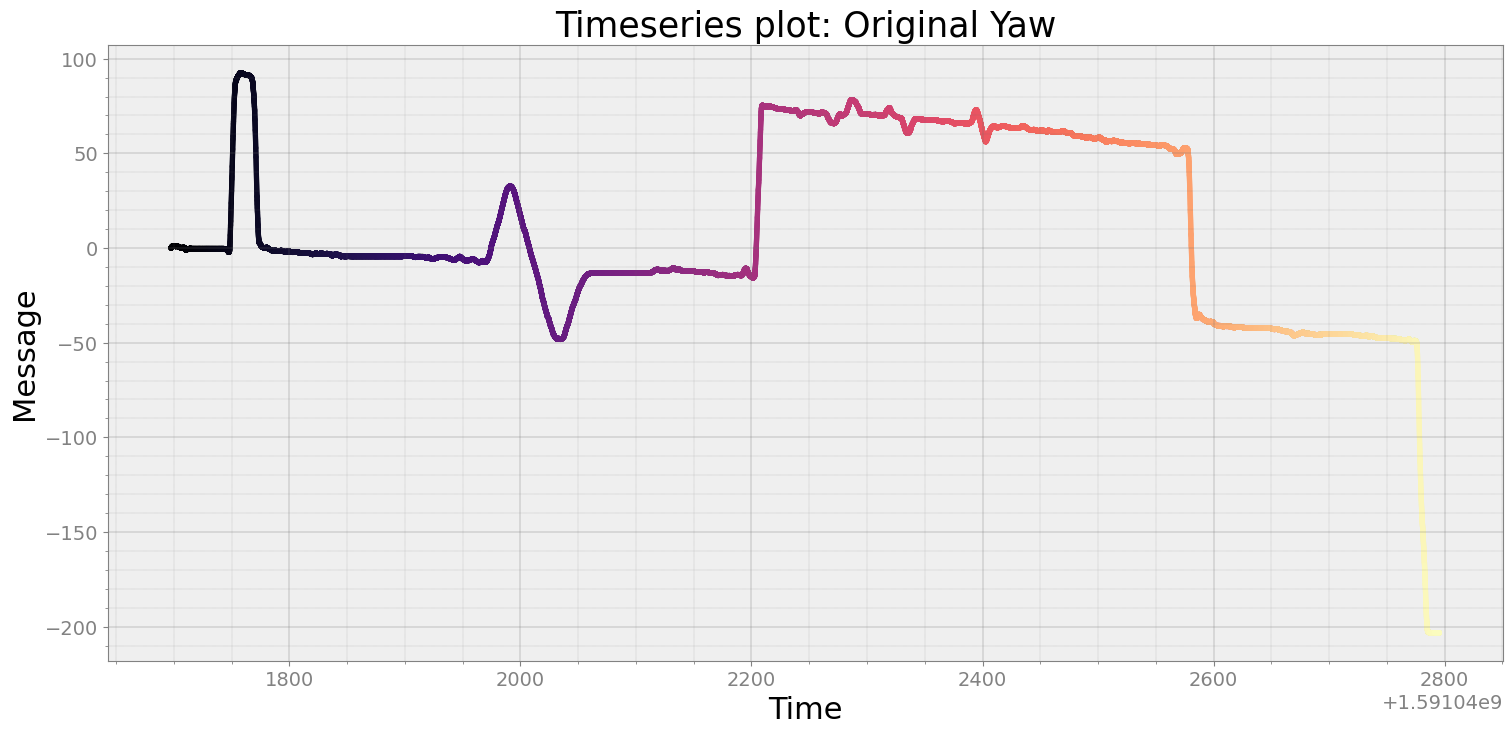

In [12]:
strymread.plt_ts(interpolated_yaw, title="Interpolated Yaw")
strymread.plt_ts(ts_yaw, title="Original Yaw")

## Plot the trajectory of vehice based on kinematic model using yaw rate and speed

In [13]:
T = r.trajectory()

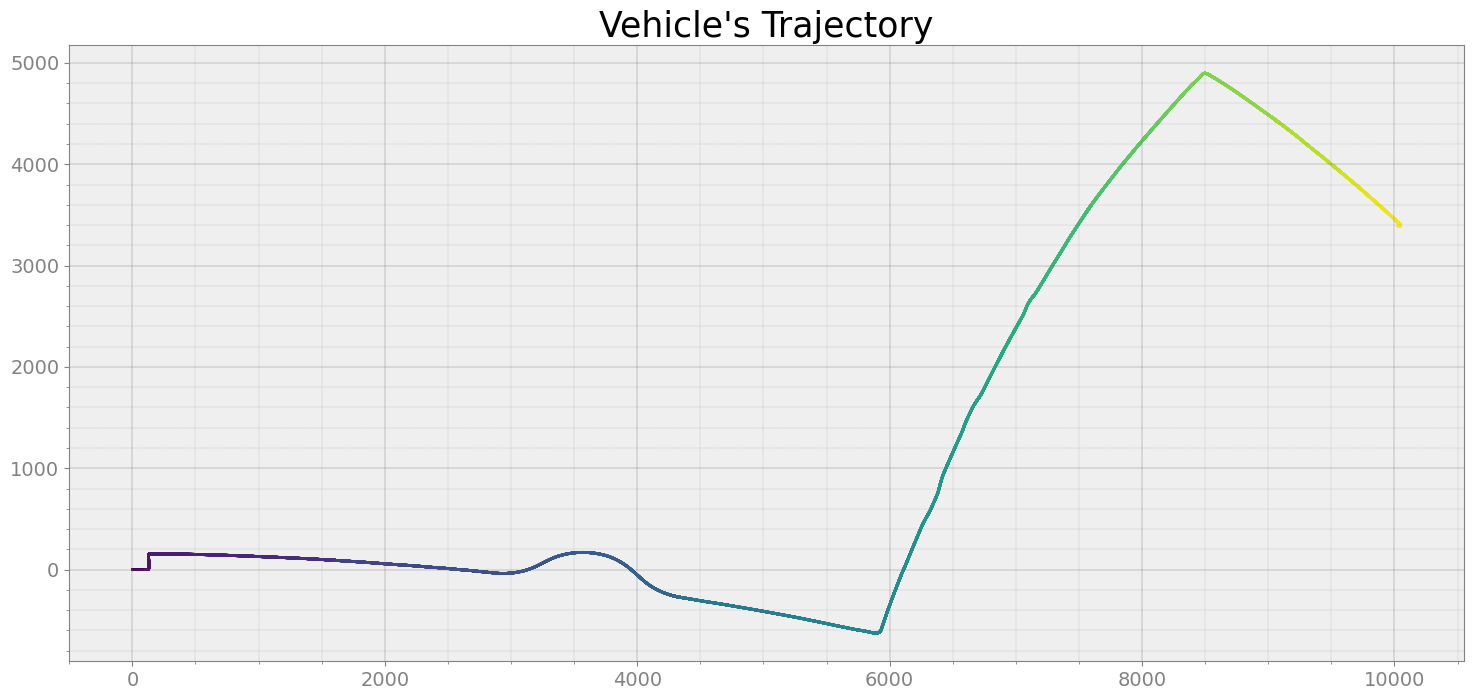

In [14]:
fig, ax = strymread.create_fig(1)
ax[0].scatter(x = 'X', y = 'Y', c = 'Time', data = T, s = 1)
ax[0].set_title("Vehicle's Trajectory")
plt.show()

In [15]:
T[1:7500]

,Time,X,Y,Vx,Vy
1,1.591042e+09,0.076889,0.000001,3.844444,0.000055
2,1.591042e+09,0.159306,0.000071,4.120851,0.003512
3,1.591042e+09,0.246237,0.000209,4.346545,0.006890
4,1.591042e+09,0.336663,0.000399,4.521301,0.009474
5,1.591042e+09,0.429092,0.000633,4.621473,0.011701
...,...,...,...,...,...
7495,1.591042e+09,1505.749024,99.366560,16.675783,-1.306036
7496,1.591042e+09,1506.082129,99.340442,16.655216,-1.305881
7497,1.591042e+09,1506.414734,99.314334,16.630274,-1.305411
7498,1.591042e+09,1506.746662,99.288252,16.596424,-1.304107


## Get the meta data about driving 
`driving_characteristics` function will give dictionary formatted meta data of the drive being analyzed.

In [16]:
metadata = r.driving_characteristics()

In [17]:
metadata

{'filename': '../../PandaData/2020_06_01/2020-06-01-13-01-36_2T3Y1RFV8KC014025_CAN_Messages.csv',
 'dbcfile': '/home/ivory/anaconda3/envs/dbn/lib/python3.7/site-packages/strym-0.2.2-py3.7.egg/strym/dbc/toyota_rav4_2019.dbc',
 'distance_meters': 14631.19081597858,
 'distance_km': 14.631190815978579,
 'distance_miles': 9.09142307777013,
 'start_time': 'Mon Jun  1 13:01:37 2020',
 'end_time': 'Mon Jun  1 13:19:55 2020',
 'trip_time': 1097.749980211258}

## Get the distribution of data
### We will show the distribution of speed data

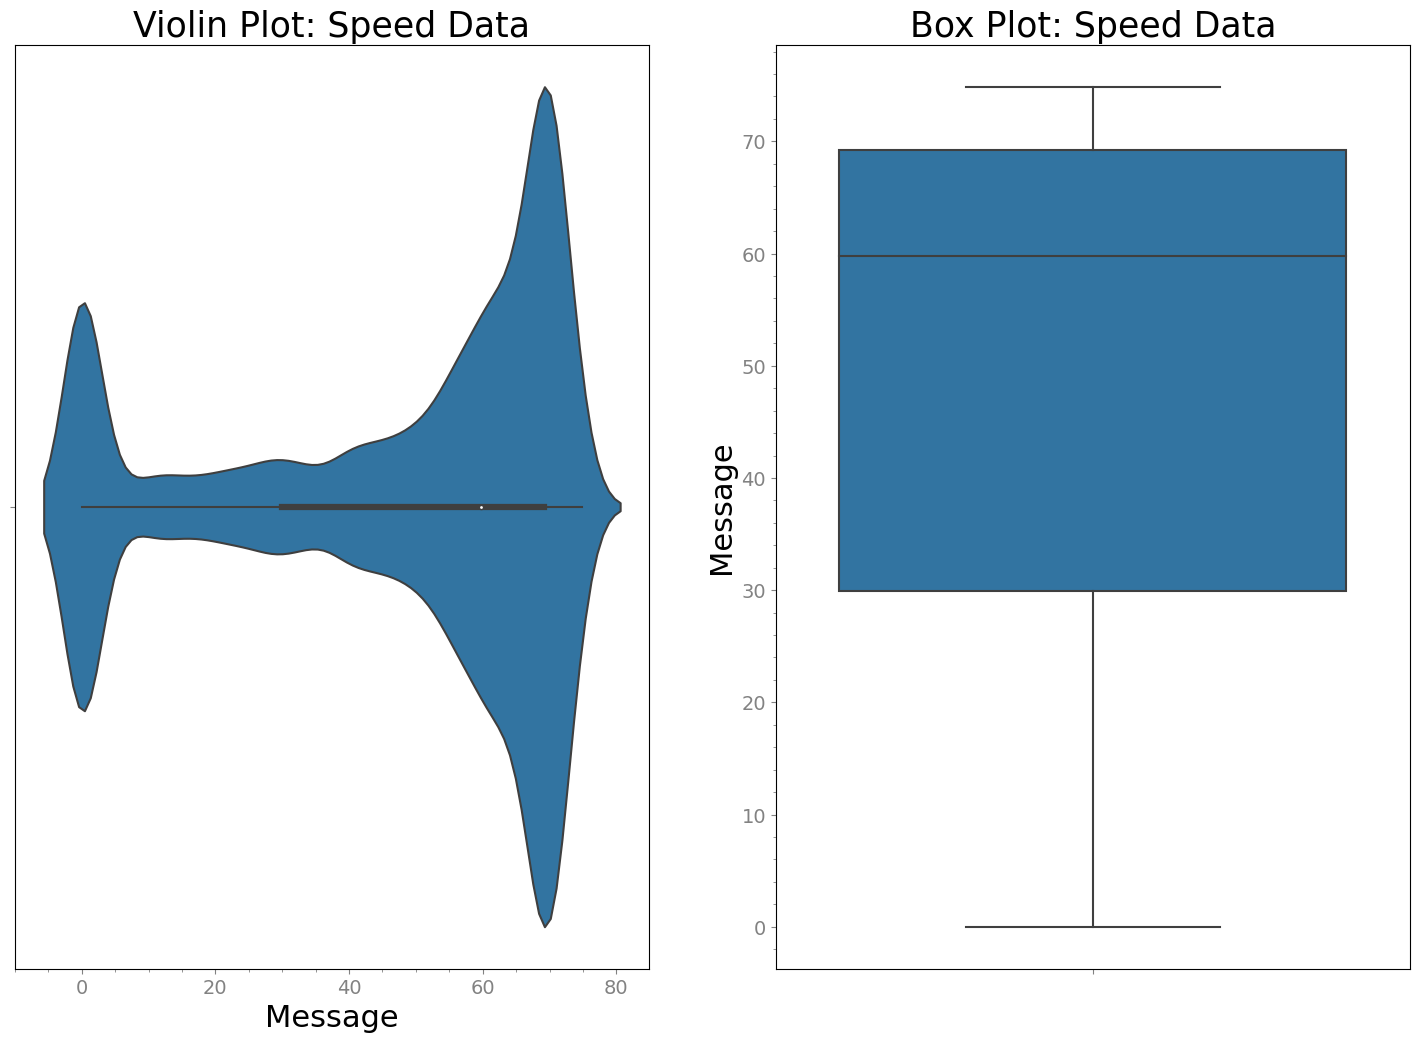

In [18]:
speed = r.speed()
strymread.violinplot(speed['Message'], title="Speed Data")

## Rate Analysis for specific messages
Let's say we want to analyze data throughput aka rate for Radar data.
For this specific example, we will be looking at TRACK_A_0. For that we will call the appropriate function to retreive longitudinal data corresponding to TRACK_A_0.

Analyzing Timestamp and Data Rate of Longitudinal Distance Data: TRACK A 0
Interquartile Range of Rate for Longitudinal Distance Data: TRACK A 0 is 0.18910648197294577 


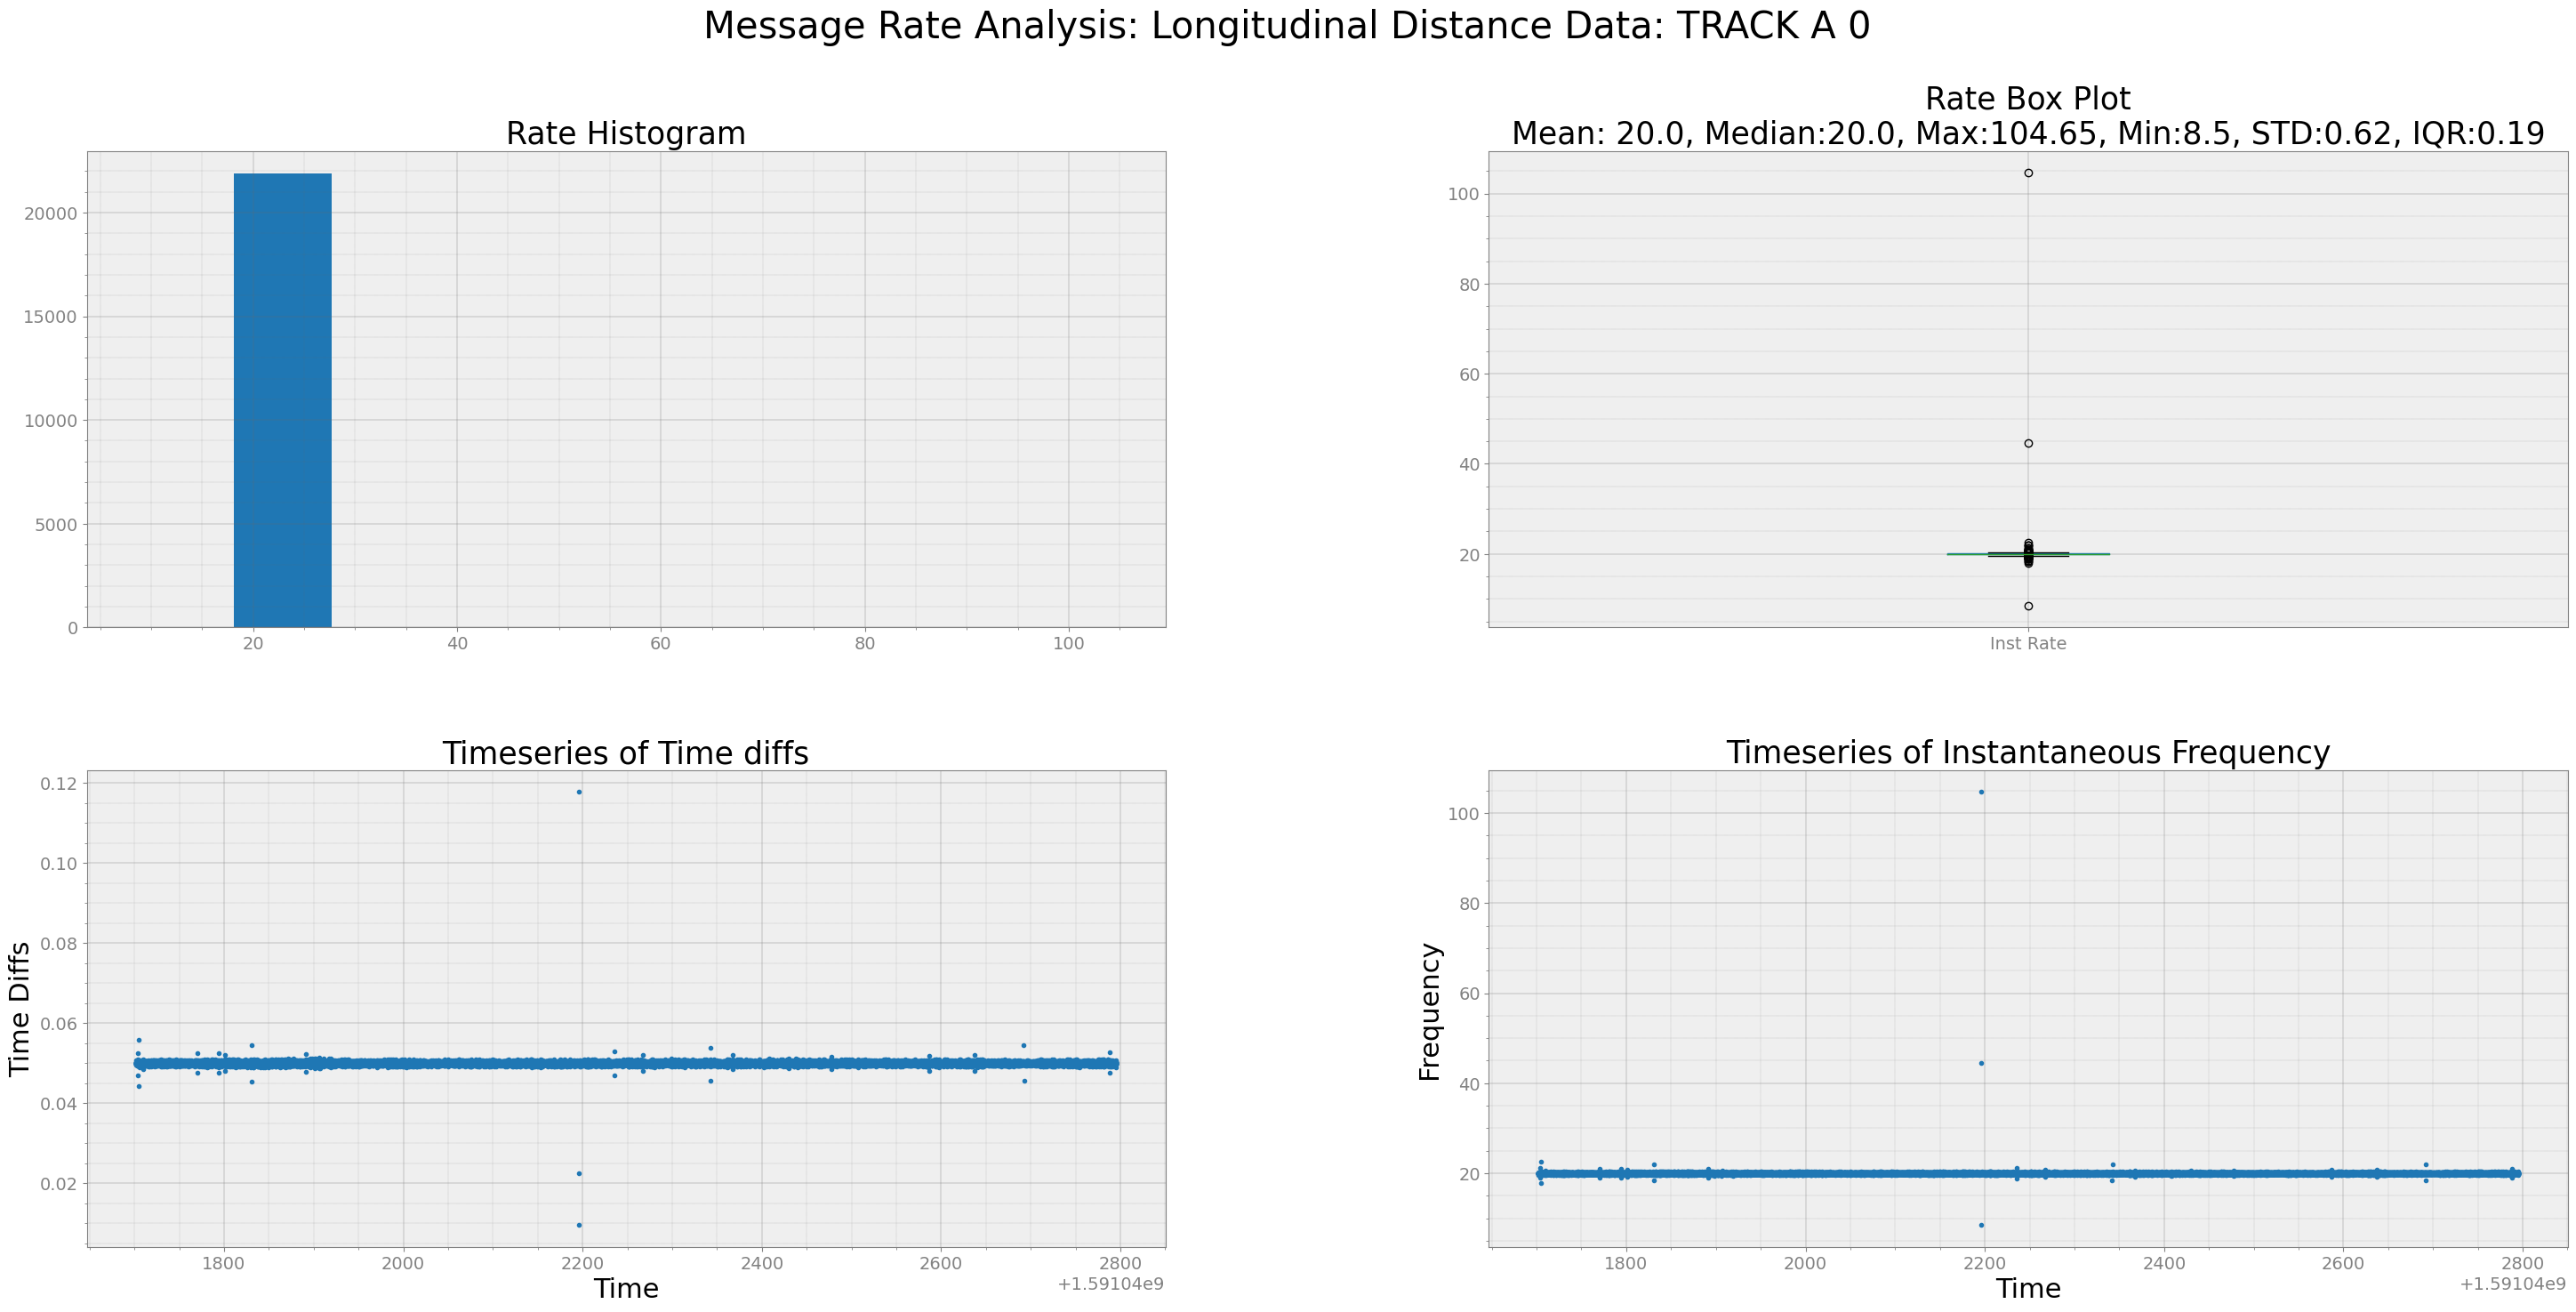

In [23]:
long_dist = r.long_dist(track_id=0) # I want to analyze rate for TRACK_A_0 only
long_dist
strymread.ranalyze(long_dist, title='Longitudinal Distance Data: TRACK A 0')

The above plot shows that, we receive RADAR data on TRACK A 0 at roughly 20 Hz in more or less consistent manner.

## Extract Data for use in MATLAB
Often we want to extract data for analysis in MATLAB or let say your collaborator is not well-versed in Python but want data suitable for Analysis in MATLAB, in that case, we can extract data for use in MATLAB and it will save the data as .mat file.

In [24]:
files = r.export2mat(force_rewrite=True) #force_rewrite overwrites an already existing mat file if you had one previously

Overwriting ...

Extracting KINEMATICS
	YAW_RATE
	STEERING_TORQUE
	ACCEL_Y
Extracting STEER_ANGLE_SENSOR
	STEER_ANGLE
	STEER_FRACTION
	STEER_RATE
Extracting BRAKE
	BRAKE_AMOUNT
	BRAKE_PEDAL
Extracting WHEEL_SPEEDS
	WHEEL_SPEED_FR
	WHEEL_SPEED_FL
	WHEEL_SPEED_RR
	WHEEL_SPEED_RL
Extracting SPEED
	ENCODER
	SPEED
	CHECKSUM
Extracting UKNOWN186
	UNKNOW186_1
Extracting UKNOWN291
	UNKNOWN291_1
	UNKNOWN291_2
	UNKNOWN291_3
Extracting UKNOWN295
	UNKNOWN295_1
	UNKNOWN295_2
	UNKNOWN295_3
Extracting UKNOWN296
	UNKNOWN296_1
	UNKNOWN296_2
	UNKNOWN296_3
Extracting DSU_SPEED
	FORWARD_SPEED
Extracting STEERING_IPAS_COMMA
	STATE
	ANGLE
	SET_ME_X10
	DIRECTION_CMD
	SET_ME_X40
	SET_ME_X00
	CHECKSUM
Extracting TRACK_A_0
	COUNTER
	LONG_DIST
	LAT_DIST
	NEW_TRACK
	REL_SPEED
	VALID
	CHECKSUM
Extracting TRACK_A_1
	COUNTER
	LONG_DIST
	LAT_DIST
	NEW_TRACK
	REL_SPEED
	VALID
	CHECKSUM
Extracting TRACK_A_2
	COUNTER
	LONG_DIST
	LAT_DIST
	NEW_TRACK
	REL_SPEED
	VALID
	CHECKSUM
Extracting TRACK_A_3
	COUNTER
	LONG_DIST
	LA

Extracting VIN_PART_3
	VIN_17
Extracting INT_SPEED
	INT_SPEED
Extracting UI_SETTING
	UNITS
Extracting STEERING_LEVERS
	TURN_SIGNALS
Extracting SEATS_DOORS
	DOOR_OPEN_FL
	DOOR_OPEN_FR
	DOOR_OPEN_RR
	DOOR_OPEN_RL
	SEATBELT_DRIVER_UNLATCHED
Extracting LIGHT_STALK
	AUTO_HIGH_BEAM
Extracting RSA1
	TSGN1
	TSGNGRY1
	TSGNHLT1
	SPDVAL1
	SPLSGN1
	SPLSGN2
	TSGN2
	TSGNGRY2
	TSGNHLT2
	SPDVAL2
	BZRRQ_P
	BZRRQ_A
	SYNCID1
Extracting RSA2
	TSGN3
	TSGNGRY3
	TSGNHLT3
	SPLSGN3
	SPLSGN4
	TSGN4
	TSGNGRY4
	TSGNHLT4
	DPSGNREQ
	SGNNUMP
	SGNNUMA
	SPDUNT
	TSRWMSG
	SYNCID2
Extracting RSA3
	TSREQPD
	TSRMSW
	OTSGNNTM
	NTLVLSPD
	OVSPNTM
	OVSPVALL
	OVSPVALM
	OVSPVALH
	TSRSPU
Extracting U1572
	ABC
	XYZ
	PQR
Extracting U1592
	ABC
	XYZ
	PQR
Extracting U1594
	ABC
	XYZ
	PQR
Extracting U1595
	YEAR
	MONTH
	DAY
	HOUR
	MINUTE
	GMT_DIFF
	GMTDIFF_HOURS
	GMTDIFF_MINUTES
	SUMMER
Extracting U1649
	ABC
	XYZ
	PQR
Extracting U1696
	ABC
	XYZ
	PQR
Extracting U1745
	ABC
	XYZ
	PQR
Extracting U1775
	ABC
	XYZ
	PQR
Extracting U1779
	ABC
	XY

The mat file save has the same name as that of original csvfile passed to strymread object but with extension .mat